In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
from tqdm import tqdm
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from util import save_topk_words
import nltk
from nltk.util import bigrams
import spacy

nlp = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv("../data/transcripts_normalized.csv", header=0)
df.dropna(subset=["transcript"], inplace=True)
df.head()

,video_id,transcript
0,AAHiZ-c88ec,man im getting frustrated water heater deliver...
1,AEsRr-ZnzNc,start give shoutout rokukun vyonder harry stac...
2,AJpzk-aFZPU,test number alright okay oh go ground oh god c...
3,AONXX-h9SdI,gonna play something brand new album came octo...
4,AOZIY-AwsjM,music


In [3]:
def get_kmeans(tfidf: np.ndarray, n_clusters: int):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(tfidf)
    return kmeans

def get_tfidf(df: pd.DataFrame):
    tf_idf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tf_idf_vectorizer.fit_transform(df["transcript"])
    return tfidf_matrix, tf_idf_vectorizer

In [4]:
cluster_sizes = list(range(10, 51))
measures = []
kms = []

tfidf_matrix, tfidf_vec = get_tfidf(df)

for n in tqdm(cluster_sizes):
    km = get_kmeans(tfidf_matrix, n)
    kms.append(km)
    measures.append({
            "n_clusters": n,
            "inertia": km.inertia_,
            "silhouette_score": silhouette_score(tfidf_matrix, km.labels_),
            "davies_bouldin_score": davies_bouldin_score(tfidf_matrix.toarray(), km.labels_),
            "calinski_harabasz_score": calinski_harabasz_score(tfidf_matrix.toarray(), km.labels_)
        })

  0%|          | 0/41 [00:00<?, ?it/s]/opt/anaconda3/envs/ytb/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 41/41 [02:47<00:00,  4.09s/it]


/var/folders/kb/q1ny0m2n19vbs1hvhhqxvp2h0000gn/T/ipykernel_56367/3523393001.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


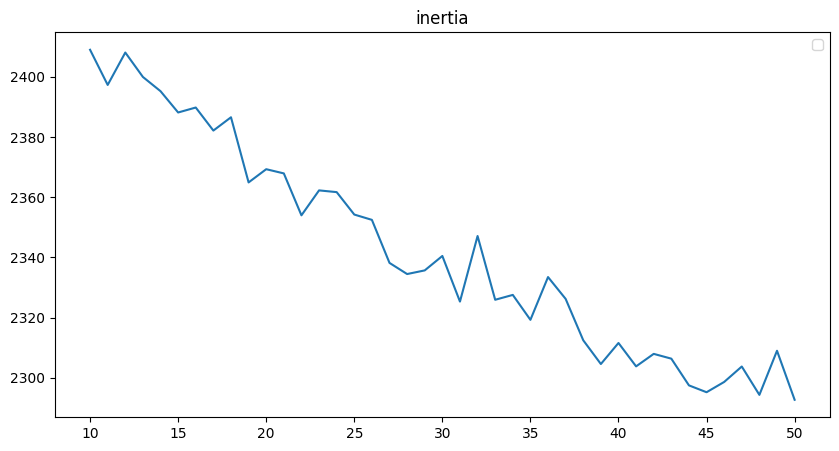

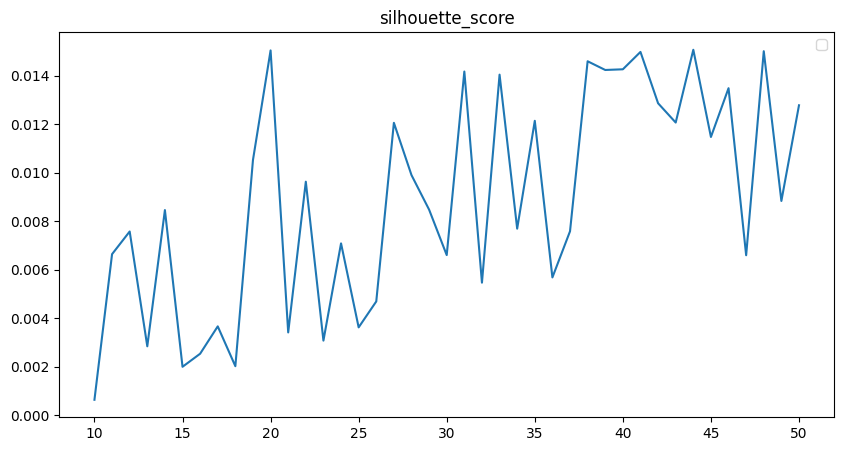

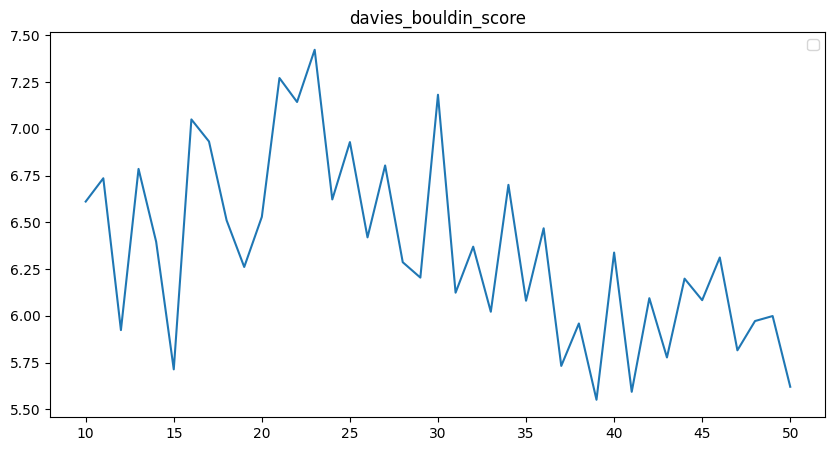

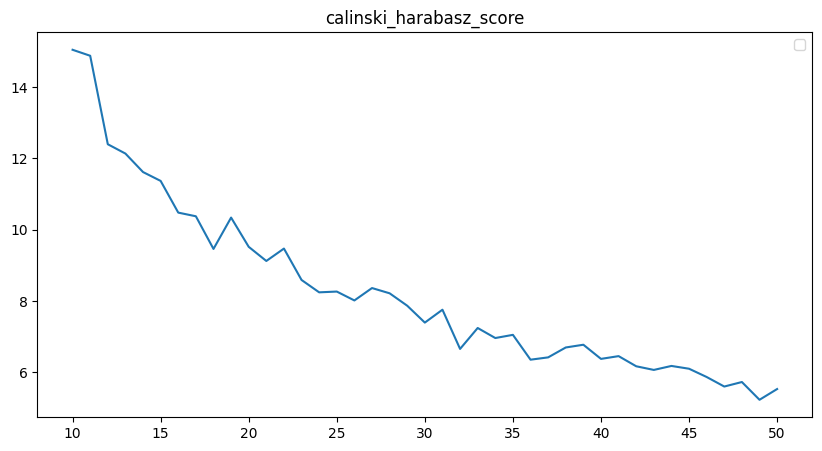

In [5]:
# plot measures for the same corpus, for different number of clusters
plot_attributes = ["inertia", "silhouette_score", "davies_bouldin_score", "calinski_harabasz_score"]
for attribute in plot_attributes:
    plt.figure(figsize=(10, 5))
    plt.plot(cluster_sizes, [m[attribute] for m in measures], )
    plt.title(attribute)
    plt.legend()
    plt.savefig(f"../figures/tfidf_baseline_measure_{attribute}.png")
    plt.show()

# inertia: lower better
# silhouette_score: higher better
# davies_bouldin_score: lower better
# calinski_harabasz_score: higher better

In [5]:
from collections import Counter
from itertools import combinations

In [6]:
# calculate PMI
tokenizes_docs = df["transcript"].str.split().to_numpy()

word_counts = Counter()
bigram_counts = Counter()

for tokens in tokenizes_docs:
    word_counts.update(tokens)
    bigram_counts.update(bigrams(tokens))

total_words = sum(word_counts.values())

In [7]:
def compute_pmi(word_list):
    pairs = list(combinations(word_list, 2))
    pmis = []

    for w1, w2 in pairs:
        if w1 in word_counts and w2 in word_counts and (w1, w2) in bigram_counts:
            p_w1 = word_counts[w1] / total_words
            p_w2 = word_counts[w2] / total_words
            p_w1_w2 = bigram_counts[(w1, w2)] / total_words
            
            if p_w1_w2 > 0:
                pmi = np.log(p_w1_w2 / (p_w1 * p_w2))
                pmis.append(pmi)
    
    return np.mean(pmis) if pmis else 0

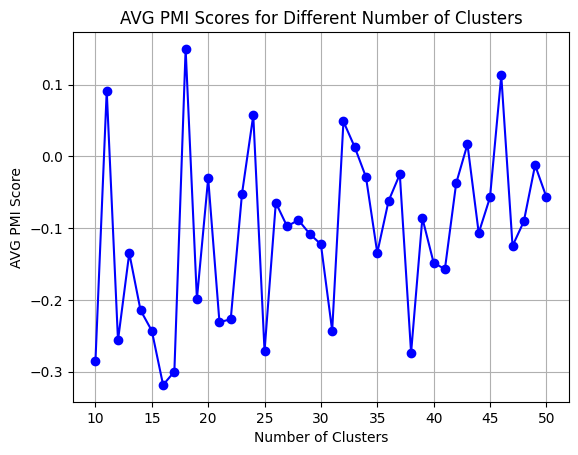

In [8]:
pmi_scores = []
for i in range(len(kms)):
    labels = kms[i].labels_
    n_clusters = len(set(labels))
    
    model_pmi = []
    for label in range(n_clusters):
        cluster_mask = labels == label
        cluster_docs = df[cluster_mask]["transcript"].tolist()
        words = " ".join(cluster_docs).split()
        wc = Counter(words)
        top_words = [t[0] for t in wc.most_common(25)] # use top 25 words for PMI calculation
        model_pmi.append(compute_pmi(top_words))
    
    pmi_scores.append(np.mean(model_pmi))

plt.plot(cluster_sizes, pmi_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('AVG PMI Score')
plt.title('AVG PMI Scores for Different Number of Clusters')
plt.grid(True)
plt.show()


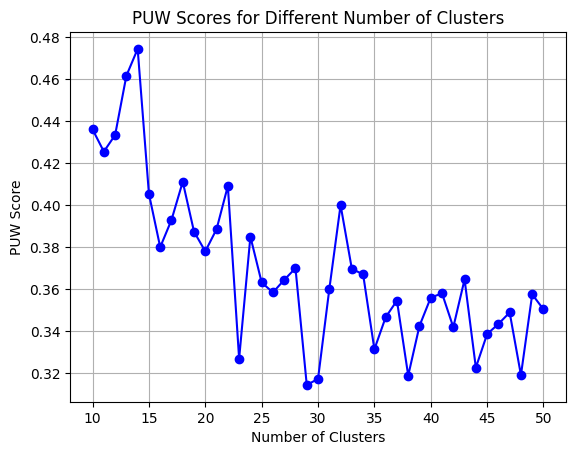

In [9]:
def proportion_unique_words(topics, topk=25):
    unique_words = set()
    for topic in topics:
        unique_words = unique_words.union(set(topic[:topk]))
    puw = len(unique_words) / (topk * len(topics))
    return puw

puws = []
for i in range(len(kms)):
    labels = kms[i].labels_
    n_clusters = len(set(labels))

    topics = []
    for label in range(n_clusters):
        cluster_mask = labels == label
        cluster_docs = df[cluster_mask]["transcript"].tolist()
        words = " ".join(cluster_docs).split()
        wc = Counter(words)
        topics.append([w[0] for w in wc.most_common(25)])
    
    puws.append(proportion_unique_words(topics))

plt.plot(cluster_sizes, puws, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('PUW Score')
plt.title('PUW Scores for Different Number of Clusters')
plt.grid(True)
plt.show()

In [8]:
if 'word_count' not in df.columns:
    df['word_count'] = df['transcript'].str.split().str.len()

for i in range(0, len(kms), 10):
    labels = kms[i].labels_
    n_clusters = len(set(labels))
    
    print(f"\nFor k-means with {n_clusters} clusters:")
    
    for label in range(n_clusters):
        cluster_mask = labels == label
        cluster_lengths = df[cluster_mask]['word_count']
        
        print(f"\nCluster {label}:")
        print(f"  Mean length: {cluster_lengths.mean():.1f}")
        print(f"  Median length: {cluster_lengths.median():.1f}")
        print(f"  Min length: {cluster_lengths.min()}")
        print(f"  Max length: {cluster_lengths.max()}")
        print(f"  Size: {len(cluster_lengths)} documents")


For k-means with 10 clusters:

Cluster 0:
  Mean length: 382.1
  Median length: 22.5
  Min length: 1
  Max length: 3672
  Size: 54 documents

Cluster 1:
  Mean length: 815.1
  Median length: 327.0
  Min length: 1
  Max length: 19397
  Size: 559 documents

Cluster 2:
  Mean length: 1651.1
  Median length: 809.0
  Min length: 1
  Max length: 21641
  Size: 236 documents

Cluster 3:
  Mean length: 122.7
  Median length: 38.0
  Min length: 1
  Max length: 5182
  Size: 189 documents

Cluster 4:
  Mean length: 147.4
  Median length: 36.0
  Min length: 1
  Max length: 6191
  Size: 1067 documents

Cluster 5:
  Mean length: 1015.2
  Median length: 416.0
  Min length: 1
  Max length: 14567
  Size: 207 documents

Cluster 6:
  Mean length: 396.4
  Median length: 100.0
  Min length: 1
  Max length: 17532
  Size: 186 documents

Cluster 7:
  Mean length: 97.1
  Median length: 18.0
  Min length: 1
  Max length: 2669
  Size: 57 documents

Cluster 8:
  Mean length: 49.1
  Median length: 1.0
  Min length

In [6]:
# save_topk_words("../topk/tfidf/tfidf", df, kms, 25, (10, 51, 1), True)

In [7]:
# def save_topk_words(df, km, nc, k):
#     text_buffer = ""
#     cluster_words = []
#     for i in range(km.n_clusters):
#         cluster_mask = km.labels_ == i
#         cluster_docs = df[cluster_mask]["transcript"].tolist()

#         words = " ".join(cluster_docs).split()
#         wc = Counter(words)
#         top_words = wc.most_common(k)
#         cluster_words.append(top_words)

#         text_buffer += f"\nCluster {i} top {k} words:\n"
#         for w, c in top_words:
#             text_buffer += f"{w}: {c}\n"
        
#     with open(f"topk/baseline_tfidf_{nc}_{k}.txt", "+w") as f:
#         f.write(text_buffer)

In [8]:
# for nc in range(10, 20):
#     idx = nc-10
#     save_topk_words(df, kms[idx], nc, 25)